![IMDb_Logo](https://miro.medium.com/max/875/1*AaSAGUqdtt0SFfz2i9Hr3w.png)

IMDb: an online database of information related to films, television programs, home videos, video games, and streaming content online — including cast, production crew and personal biographies, plot summaries, trivia, fan and critical reviews, and ratings.

## Downloading and Importing Data

In [4]:
!pip install opendatasets

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'
od.download(dataset_url)

  0%|          | 0.00/25.7M [00:00<?, ?B/s]

100%|██████████| 25.7M/25.7M [00:01<00:00, 16.1MB/s]


In [10]:
import pandas as pd

df = pd.read_csv('./imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = (['The sun is shining',
         'The weather is sweet',
         'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

print(count.vocabulary_)
print(bag.toarray())

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}
[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
np.set_printoptions(precision=2)

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

print(tfidf.fit_transform(bag).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


## Data Preparation: Cleaning and Preprocessing

In [16]:
import re
def preprocessor(text):
  text =re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
  
  return text

preprocessor("This is a :) test :-( !")

'this is a test :) :('

In [18]:
# preprocess data
df['review'] = df['review'].apply(preprocessor)

## Tokenization of Documents

In [20]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
  return text.split()

def tokenizer_stemmer(text):
  return[porter.stem(word) for word in text.split()]

tokenizer('runners like running thus they run')

['runners', 'like', 'running', 'thus', 'they', 'run']

In [21]:
tokenizer_stemmer('runners like running thus they run')

['runner', 'like', 'run', 'thu', 'they', 'run']

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_stemmer('runners like running thus they run') if w not in stop]

['runner', 'like', 'run', 'thu', 'run']

## Transform Text Data into TD-IDF Vectors

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=True,
                         preprocessor=None,  # applied preprocessor in Data Cleaning
                         tokenizer=tokenizer_stemmer,
                         use_idf=True,
                         norm='l2',
                         smooth_idf=True)

y = df.sentiment.values
X = tfidf.fit_transform(df.review)

## Document Classification using Logistic Regression

In [25]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5, shuffle=False)

clf = LogisticRegressionCV(cv=5,
                           scoring='accuracy',
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [26]:
saved_model = open('saved_model.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()

## Model Evaluation

In [27]:
filename = 'saved_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

In [28]:
clf.score(X_test, y_test)

0.89472

In [29]:
yhat = clf.predict(X_test)
yhat

array(['negative', 'negative', 'positive', ..., 'positive', 'negative',
       'negative'], dtype=object)

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=['positive', 'negative']))

[[11323  1203]
 [ 1429 11045]]


Confusion matrix, without normalization
[[11323  1203]
 [ 1429 11045]]


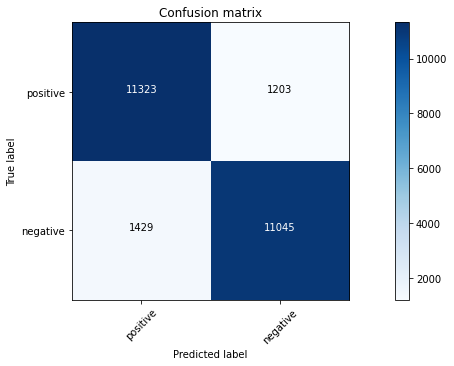

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['positive','negative'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(13,5))
plot_confusion_matrix(cnf_matrix, classes=['positive','negative'],normalize= False,  title='Confusion matrix')